In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
aapl = yf.Ticker("AAPL").history(period="1y")
amzn = yf.Ticker("AMZN").history(period="1y")
nke = yf.Ticker("NKE").history(period="1y")
mcd = yf.Ticker("MCD").history(period="1y")
koss = yf.Ticker("KOSS").history(period="1y")
ko = yf.Ticker("KO").history(period="1y")
pg = yf.Ticker("PG").history(period="1y")
eman = yf.Ticker("EMAN").history(period="1y")
ba = yf.Ticker("BA").history(period="1y")
msft = yf.Ticker("MSFT").history(period="1y")

In [3]:
aapl_open = np.flip(np.array(aapl.Open))
amzn_open = np.flip(np.array(amzn.Open))
nke_open = np.flip(np.array(nke.Open))
mcd_open = np.flip(np.array(mcd.Open))
koss_open = np.flip(np.array(koss.Open))
ko_open = np.flip(np.array(ko.Open))
pg_open = np.flip(np.array(pg.Open))
eman_open = np.flip(np.array(eman.Open))
ba_open = np.flip(np.array(ba.Open))
msft_open = np.flip(np.array(msft.Open))

data_open = np.array([aapl_open, amzn_open, nke_open, mcd_open, koss_open, ko_open, pg_open, eman_open, ba_open, msft_open])


aapl_close = np.flip(np.array(aapl.Close))
amzn_close = np.flip(np.array(amzn.Close))
nke_close = np.flip(np.array(nke.Close))
mcd_close = np.flip(np.array(mcd.Close))
koss_close = np.flip(np.array(koss.Close))
ko_close = np.flip(np.array(ko.Close))
pg_close = np.flip(np.array(pg.Close))
eman_close = np.flip(np.array(eman.Close))
ba_close = np.flip(np.array(ba.Close))
msft_close = np.flip(np.array(msft.Close))

data_close = np.array([aapl_close, amzn_close, nke_close, mcd_close, koss_close, ko_close, pg_close, eman_close, ba_close, msft_close])


aapl_volume = np.flip(np.array(aapl.Volume))
amzn_volume = np.flip(np.array(amzn.Volume))
nke_volume = np.flip(np.array(nke.Volume))
mcd_volume = np.flip(np.array(mcd.Volume))
koss_volume = np.flip(np.array(koss.Volume))
ko_volume = np.flip(np.array(ko.Volume))
pg_volume = np.flip(np.array(pg.Volume))
eman_volume = np.flip(np.array(eman.Volume))
ba_volume = np.flip(np.array(ba.Volume))
msft_volume = np.flip(np.array(msft.Volume))

data_volume = np.array([aapl_volume, amzn_volume, nke_volume, mcd_volume, koss_volume, ko_volume, pg_volume, eman_volume, ba_volume, msft_volume])

### Profit and loss
Profit and loss для определенного дня t:
$$ p\&l(t) = \alpha(t)\left({P(t) \over P(t + 1)} - 1\right)$$
Cum profit and loss для дня t:
$$ p\&l^{cum}(S) = \sum_{t = 0}^{S} p\&l(t)$$

In [4]:
def profit_and_loss(data_open, data_close, data_volume, func_alpha, t):
    alpha = func_alpha(data_open[:, t + 1:], data_close[:, t + 1:], data_volume[:, t + 1:])
    return sum((data_close[:,t] / data_close[:, t + 1] - 1) * alpha)

In [5]:
def cum_profit_and_loss(data_open, data_close, data_volume, func_alpha, start):
    answer = np.zeros(start)
    for i in range(start - 2, -1, -1):
        answer[i] = answer[i + 1] + profit_and_loss(data_open, data_close, data_volume, func_alpha, i)
    return answer[::-1]

In [6]:
def show_profit_and_loss(p_and_l_data):
    print('min:', min(p_and_l_data)) 
    print('max:', max(p_and_l_data))
    print('last value:', p_and_l_data[-1])
    plt.rcParams['font.size'] = '15'
    fig, ax = plt.subplots()
    plt.plot(np.linspace(0, len(p_and_l_data), len(p_and_l_data)), p_and_l_data)

    ax.grid(color = 'black',    #  цвет линий
                linewidth = 0.5,    #  толщина
                linestyle = '-')    #  начертание
    plt.legend(loc = 'best', fancybox = True, shadow = True)

    #plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))  # интервал написания значений оси OX
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.05))  # интервал написания значений оси OY
    plt.xticks(rotation=25)

    fig.set_figwidth(15)
    fig.set_figheight(8)

    plt.title('Cumulative profit and loss')
    plt.show()

##### Alpha#2
$$ alpha2 = -1 * correlation(rank(delta(log(volume), 2)), rank((close - open) / open), 6) $$
trading volume: $$ volume $$
closing price: $$ close $$
opening price: $$ open $$
today’s value of x minus the value of x d days ago: $$ delta(x, d) = V(t) - V(t + d) $$
the rank of the vector x: $$rank(x)$$
Spearman's rank correlation coefficient: $$ correlation $$

In [7]:
def delta(data_volume):
    return [np.array(np.log(data_volume)[:, i]) - np.array(np.log(data_volume)[:, i + 2]) for i in range(6)]

In [8]:
def kernel(data_open, data_close):
    return [(data_close[:, i] - data_open[:, i]) / data_open[:, i] for i in range(6)]

In [9]:
def correlation(first_data, second_data):
    return np.array([stats.spearmanr(np.array(first_data)[:, i], np.array(second_data)[:, i])[0] for i in range(len(first_data[0]))])

In [10]:
def alpha(data_open, data_close, data_volume):
    first_part = delta(data_volume)
    second_part = kernel(data_open, data_close)
    corr = np.array([stats.spearmanr(np.array(first_part)[:, i], np.array(second_part)[:, i])[0] for i in range(len(first_part[0]))])
    alpha = -(corr - np.mean(corr)) / sum(abs(corr - np.mean(corr)))
    return alpha

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min: -0.05569114562216636
max: 0.1875753381191381
last value: 0.18275140216501493


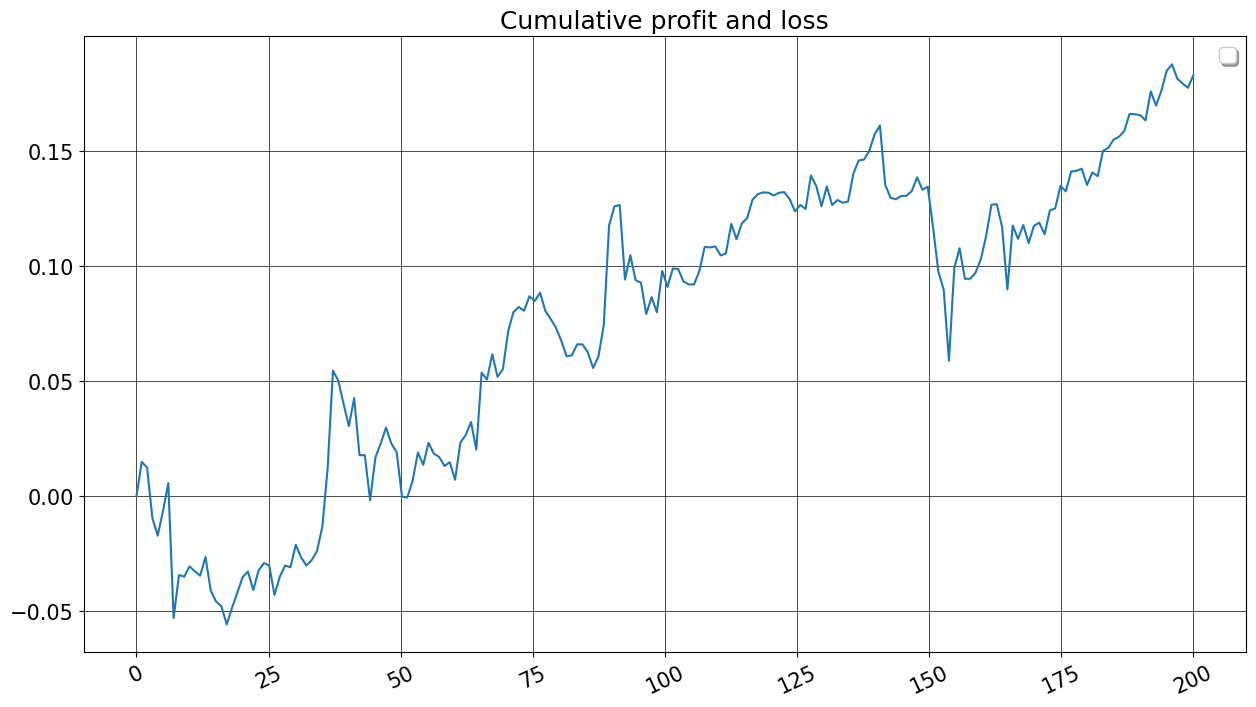

In [11]:
n = 200
show_profit_and_loss(cum_profit_and_loss(data_open, data_close, data_volume, alpha, n))